In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-crushes/Traffic_Crashes_-_Crashes_20240823.csv
/kaggle/input/traffic-crushes/Traffic_Crashes_-_People_20240823.csv
/kaggle/input/traffic-crashes/Traffic_Crashes_-_Vehicles_20241009.csv


In [2]:
# Import other dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Loading Crashes Dataset

In [3]:
crashes_df = pd.read_csv('/kaggle/input/traffic-crushes/Traffic_Crashes_-_Crashes_20240823.csv')

crashes_df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,NaN,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,...,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,NaN,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,1.0,0.0,14,7,7,41.854120,-87.665902,POINT (-87.665902342962 41.854120262952)
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,NaN,08/18/2023 05:58:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,...,1.0,0.0,1.0,0.0,17,6,8,41.942976,-87.761883,POINT (-87.761883496974 41.942975745006)
3,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,NaN,11/26/2019 08:38:00 AM,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,ONE-WAY,...,0.0,0.0,1.0,0.0,8,3,11,NaN,NaN,NaN
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,NaN,08/18/2023 10:45:00 AM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,OTHER,...,0.0,0.0,1.0,0.0,10,6,8,NaN,NaN,NaN


### Data Exploration

In [4]:
# Dataset information
crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865480 entries, 0 to 865479
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                865480 non-null  object 
 1   CRASH_DATE_EST_I               64306 non-null   object 
 2   CRASH_DATE                     865480 non-null  object 
 3   POSTED_SPEED_LIMIT             865480 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         865480 non-null  object 
 5   DEVICE_CONDITION               865480 non-null  object 
 6   WEATHER_CONDITION              865480 non-null  object 
 7   LIGHTING_CONDITION             865480 non-null  object 
 8   FIRST_CRASH_TYPE               865480 non-null  object 
 9   TRAFFICWAY_TYPE                865480 non-null  object 
 10  LANE_CNT                       199015 non-null  float64
 11  ALIGNMENT                      865480 non-null  object 
 12  ROADWAY_SURFACE_COND          

#### Investigate Column Types

In [5]:
crashes_df.dtypes

CRASH_RECORD_ID                   object
CRASH_DATE_EST_I                  object
CRASH_DATE                        object
POSTED_SPEED_LIMIT                 int64
TRAFFIC_CONTROL_DEVICE            object
DEVICE_CONDITION                  object
WEATHER_CONDITION                 object
LIGHTING_CONDITION                object
FIRST_CRASH_TYPE                  object
TRAFFICWAY_TYPE                   object
LANE_CNT                         float64
ALIGNMENT                         object
ROADWAY_SURFACE_COND              object
ROAD_DEFECT                       object
REPORT_TYPE                       object
CRASH_TYPE                        object
INTERSECTION_RELATED_I            object
NOT_RIGHT_OF_WAY_I                object
HIT_AND_RUN_I                     object
DAMAGE                            object
DATE_POLICE_NOTIFIED              object
PRIM_CONTRIBUTORY_CAUSE           object
SEC_CONTRIBUTORY_CAUSE            object
STREET_NO                          int64
STREET_DIRECTION

In [6]:
# Check for Null values
crashes_df.isna().sum()

CRASH_RECORD_ID                       0
CRASH_DATE_EST_I                 801174
CRASH_DATE                            0
POSTED_SPEED_LIMIT                    0
TRAFFIC_CONTROL_DEVICE                0
DEVICE_CONDITION                      0
WEATHER_CONDITION                     0
LIGHTING_CONDITION                    0
FIRST_CRASH_TYPE                      0
TRAFFICWAY_TYPE                       0
LANE_CNT                         666465
ALIGNMENT                             0
ROADWAY_SURFACE_COND                  0
ROAD_DEFECT                           0
REPORT_TYPE                       26375
CRASH_TYPE                            0
INTERSECTION_RELATED_I           667082
NOT_RIGHT_OF_WAY_I               825845
HIT_AND_RUN_I                    594186
DAMAGE                                0
DATE_POLICE_NOTIFIED                  0
PRIM_CONTRIBUTORY_CAUSE               0
SEC_CONTRIBUTORY_CAUSE                0
STREET_NO                             0
STREET_DIRECTION                      4


In [7]:
# Checking for missing values and their percentages
missing_values = crashes_df.isnull().sum()
missing_percentage = (missing_values / crashes_df.shape[0]) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

print(missing_data[missing_data['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False))

                               Missing Values  Percentage
WORKERS_PRESENT_I                      864225   99.854994
DOORING_I                              862766   99.686417
WORK_ZONE_TYPE                         861702   99.563479
WORK_ZONE_I                            860585   99.434418
PHOTOS_TAKEN_I                         853825   98.653348
STATEMENTS_TAKEN_I                     845751   97.720456
NOT_RIGHT_OF_WAY_I                     825845   95.420460
CRASH_DATE_EST_I                       801174   92.569903
INTERSECTION_RELATED_I                 667082   77.076536
LANE_CNT                               666465   77.005246
HIT_AND_RUN_I                          594186   68.653926
REPORT_TYPE                             26375    3.047442
LOCATION                                 6124    0.707584
LONGITUDE                                6124    0.707584
LATITUDE                                 6124    0.707584
MOST_SEVERE_INJURY                       1914    0.221149
INJURIES_REPOR

In [8]:
# Statistical summary
crashes_df.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,865480.000000,1.990150e+05,865480.000000,865475.000000,865480.000000,863579.000000,863579.000000,863579.000000,863579.000000,863579.000000,863579.000000,863579.0,865480.000000,865480.000000,865480.000000,859356.000000,859356.000000
mean,28.415999,1.332981e+01,3687.051464,1244.447204,2.035098,0.192629,0.001194,0.019818,0.108221,0.063397,2.001761,0.0,13.204545,4.121470,6.604898,41.855073,-87.673648
std,6.131936,2.961557e+03,2882.776566,705.131495,0.452753,0.570048,0.037459,0.164775,0.424219,0.323793,1.157221,0.0,5.573787,1.981602,3.378985,0.333757,0.678004
min,0.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.936193
25%,30.000000,2.000000e+00,1250.000000,714.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000,41.782864,-87.721770
50%,30.000000,2.000000e+00,3201.000000,1212.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.874946,-87.674176
75%,30.000000,4.000000e+00,5581.250000,1822.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.924489,-87.633460
max,99.000000,1.191625e+06,451100.000000,6100.000000,18.000000,21.000000,4.000000,10.000000,21.000000,15.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


In [9]:
# Check shape of the Crashes Dataset
crashes_df.shape

(865480, 48)

In [10]:
# Remove duplicates from the dataset
crashes_df.drop_duplicates(inplace=True)

crashes_df.shape

(865480, 48)

### Loading People Dataset

In [11]:
people_df = pd.read_csv('/kaggle/input/traffic-crushes/Traffic_Crashes_-_People_20240823.csv', low_memory=False)

people_df.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,M,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


### Data Exploration

In [12]:
# Dataset information
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900433 entries, 0 to 1900432
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   PERSON_ID              object 
 1   PERSON_TYPE            object 
 2   CRASH_RECORD_ID        object 
 3   VEHICLE_ID             float64
 4   CRASH_DATE             object 
 5   SEAT_NO                float64
 6   CITY                   object 
 7   STATE                  object 
 8   ZIPCODE                object 
 9   SEX                    object 
 10  AGE                    float64
 11  DRIVERS_LICENSE_STATE  object 
 12  DRIVERS_LICENSE_CLASS  object 
 13  SAFETY_EQUIPMENT       object 
 14  AIRBAG_DEPLOYED        object 
 15  EJECTION               object 
 16  INJURY_CLASSIFICATION  object 
 17  HOSPITAL               object 
 18  EMS_AGENCY             object 
 19  EMS_RUN_NO             object 
 20  DRIVER_ACTION          object 
 21  DRIVER_VISION          object 
 22  PHYSICAL_CONDITION

In [13]:
# Check Null values
people_df.isna().sum()

PERSON_ID                      0
PERSON_TYPE                    0
CRASH_RECORD_ID                0
VEHICLE_ID                 38519
CRASH_DATE                     0
SEAT_NO                  1515932
CITY                      517670
STATE                     496782
ZIPCODE                   629651
SEX                        31911
AGE                       554304
DRIVERS_LICENSE_STATE     787828
DRIVERS_LICENSE_CLASS     973377
SAFETY_EQUIPMENT            5282
AIRBAG_DEPLOYED            37056
EJECTION                   23657
INJURY_CLASSIFICATION        740
HOSPITAL                 1589731
EMS_AGENCY               1708418
EMS_RUN_NO               1868441
DRIVER_ACTION             387902
DRIVER_VISION             388469
PHYSICAL_CONDITION        386871
PEDPEDAL_ACTION          1863692
PEDPEDAL_VISIBILITY      1863759
PEDPEDAL_LOCATION        1863692
BAC_RESULT                386952
BAC_RESULT VALUE         1898345
CELL_PHONE_USE           1899273
dtype: int64

In [14]:
# Checking for missing values and their percentages
missing_values = people_df.isnull().sum()
missing_percentage = (missing_values / people_df.shape[0]) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

print(missing_data[missing_data['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False))

                       Missing Values  Percentage
CELL_PHONE_USE                1899273   99.938961
BAC_RESULT VALUE              1898345   99.890130
EMS_RUN_NO                    1868441   98.316594
PEDPEDAL_VISIBILITY           1863759   98.070229
PEDPEDAL_ACTION               1863692   98.066704
PEDPEDAL_LOCATION             1863692   98.066704
EMS_AGENCY                    1708418   89.896250
HOSPITAL                      1589731   83.650989
SEAT_NO                       1515932   79.767716
DRIVERS_LICENSE_CLASS          973377   51.218696
DRIVERS_LICENSE_STATE          787828   41.455184
ZIPCODE                        629651   33.131976
AGE                            554304   29.167248
CITY                           517670   27.239582
STATE                          496782   26.140464
DRIVER_VISION                  388469   20.441078
DRIVER_ACTION                  387902   20.411243
BAC_RESULT                     386952   20.361255
PHYSICAL_CONDITION             386871   20.356992


In [15]:
# Statistical summary
people_df.describe()

,VEHICLE_ID,SEAT_NO,AGE,BAC_RESULT VALUE
count,1.861914e+06,384501.000000,1.346129e+06,2088.000000
mean,8.941464e+05,4.163485,3.790887e+01,0.170848
std,5.198917e+05,2.214131,1.708862e+01,0.103348
min,2.000000e+00,1.000000,-1.770000e+02,0.000000
25%,4.438312e+05,3.000000,2.500000e+01,0.120000
50%,8.848925e+05,3.000000,3.500000e+01,0.170000
75%,1.346156e+06,5.000000,5.000000e+01,0.220000
max,1.799963e+06,12.000000,1.100000e+02,1.000000


In [16]:
# Check number of rows and columns
people_df.shape

(1900433, 29)

In [17]:

people_df.drop_duplicates(inplace=True)

people_df.shape

(1900433, 29)

### **Exploratory Data Analysis**

In [18]:
crashes_df.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [19]:
crashes_ = crashes_df.drop(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE', 
                 'REPORT_TYPE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME',
                 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'INJURIES_UNKNOWN', 
                 'LATITUDE', 'LONGITUDE', 'LOCATION'], axis=1)

In [20]:
# display numerical variables

crashes_eda = [col for col in crashes_.columns if crashes_[col].dtypes != 'O']

crashes_eda

['POSTED_SPEED_LIMIT',
 'LANE_CNT',
 'BEAT_OF_OCCURRENCE',
 'NUM_UNITS',
 'INJURIES_TOTAL',
 'INJURIES_FATAL',
 'INJURIES_INCAPACITATING',
 'INJURIES_NON_INCAPACITATING',
 'INJURIES_REPORTED_NOT_EVIDENT',
 'INJURIES_NO_INDICATION',
 'CRASH_HOUR',
 'CRASH_DAY_OF_WEEK',
 'CRASH_MONTH']

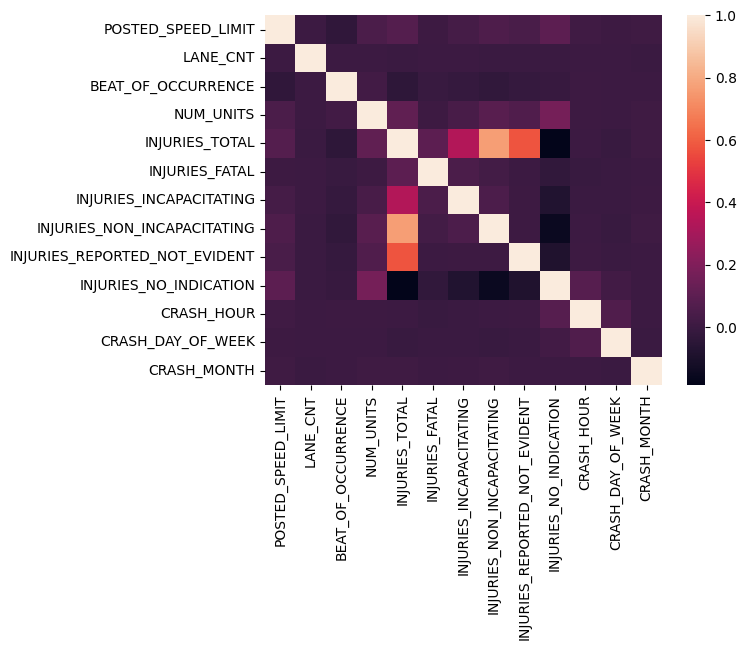

In [21]:
# Are certain factors correlated with severity of injuries?
sns.heatmap(crashes_[crashes_eda].corr());

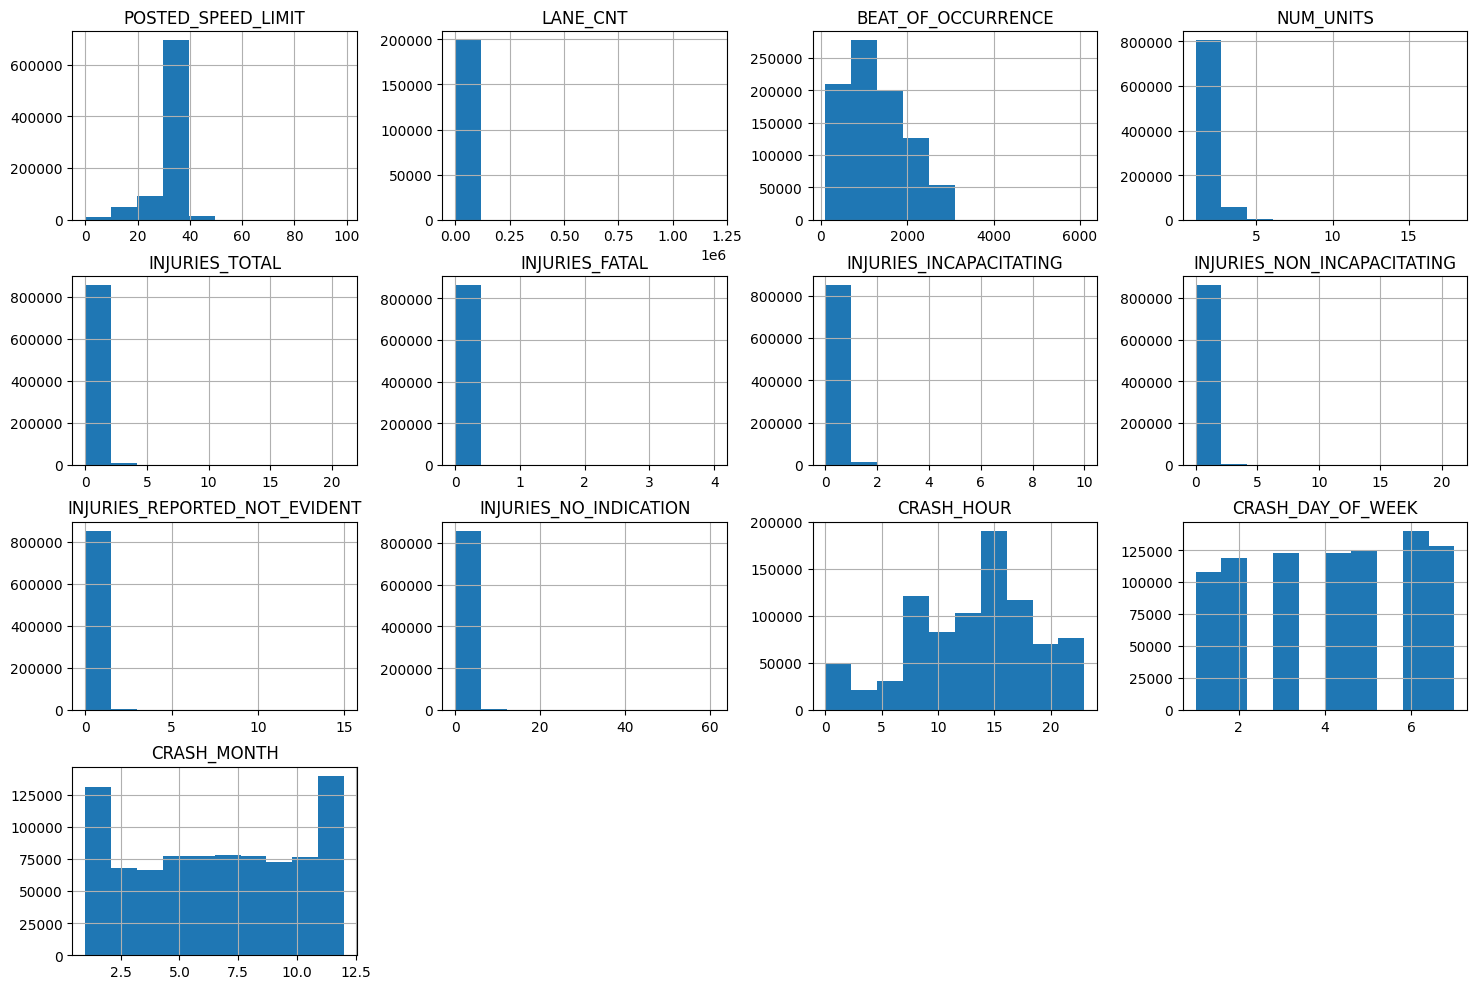

In [22]:
# Numeric variables
crashes_[crashes_eda].hist(figsize=(18, 12));

In [23]:
people_df.INJURY_CLASSIFICATION.value_counts()

INJURY_CLASSIFICATION
NO INDICATION OF INJURY     1732523
NONINCAPACITATING INJURY      93892
REPORTED, NOT EVIDENT         54977
INCAPACITATING INJURY         17249
FATAL                          1052
Name: count, dtype: int64

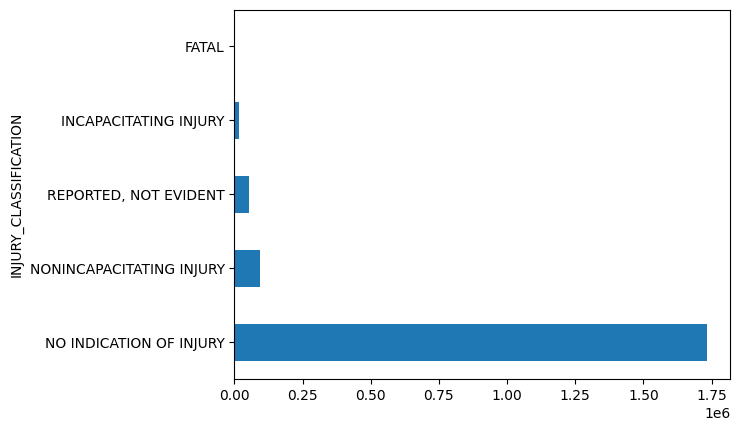

In [24]:
people_df.INJURY_CLASSIFICATION.value_counts().plot.barh();

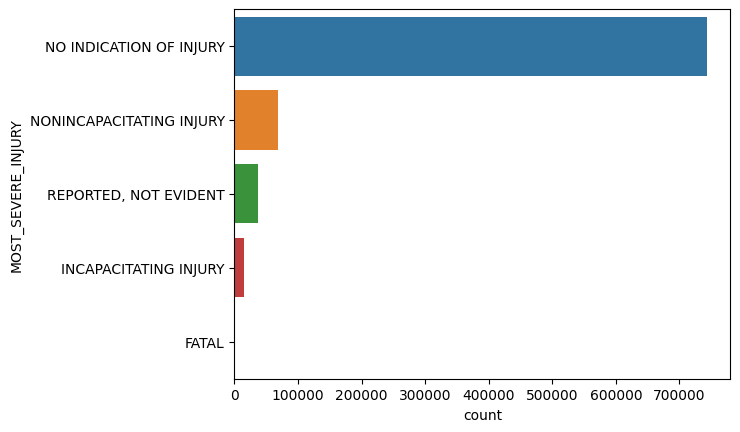

In [25]:
# Target values by crash
sns.barplot(y=crashes_.MOST_SEVERE_INJURY.value_counts().index, 
            x=crashes_.MOST_SEVERE_INJURY.value_counts(),
            orient='h');

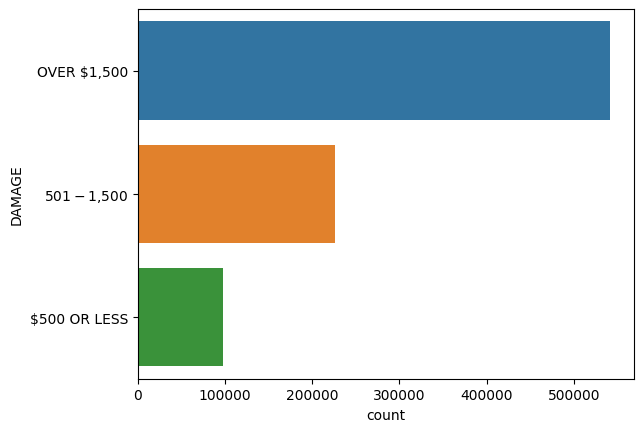

In [26]:
# Total damage in dollars
sns.barplot(y=crashes_.DAMAGE.value_counts().index, x=crashes_.DAMAGE.value_counts(), orient='h');

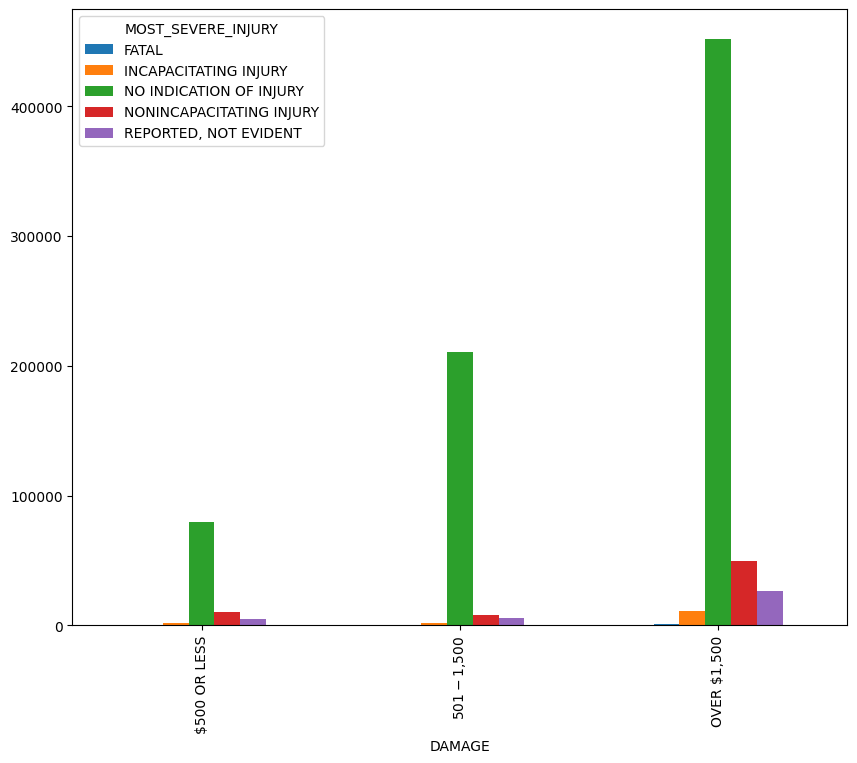

In [27]:
# Total damage disaggregated by most severe injury resulting from a crash
pd.crosstab(crashes_.DAMAGE, crashes_.MOST_SEVERE_INJURY).plot.bar(figsize=(10, 8));

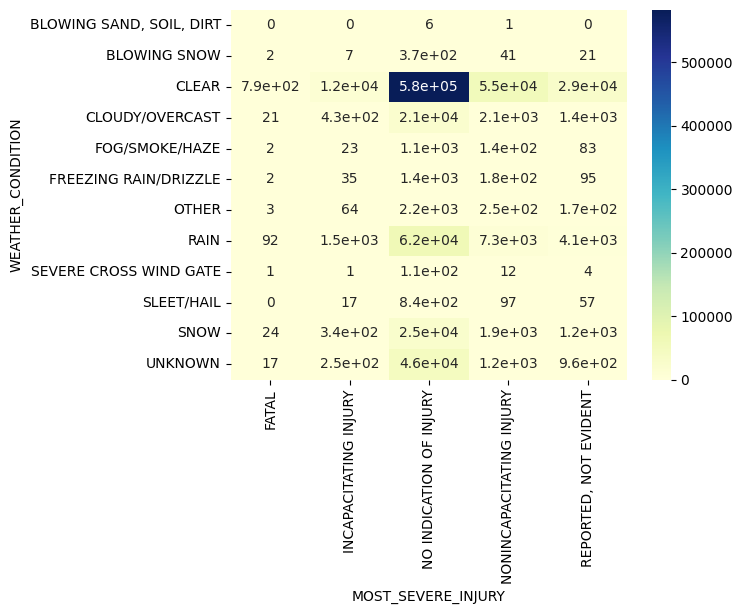

In [28]:
# How might weather affect the severity of injury resulting from a crash?
sns.heatmap(pd.crosstab(crashes_.WEATHER_CONDITION, 
                        crashes_.MOST_SEVERE_INJURY), 
            annot=True, cmap="YlGnBu");

In [29]:
people_df.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

In [30]:
people_ = people_df.drop(['PERSON_ID', 'CELL_PHONE_USE', 'BAC_RESULT VALUE', 'EMS_RUN_NO', 
                          'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'EMS_AGENCY', 'HOSPITAL', 'SEAT_NO',
                          'DRIVERS_LICENSE_CLASS', 'DRIVERS_LICENSE_STATE', 'ZIPCODE'], axis=1)

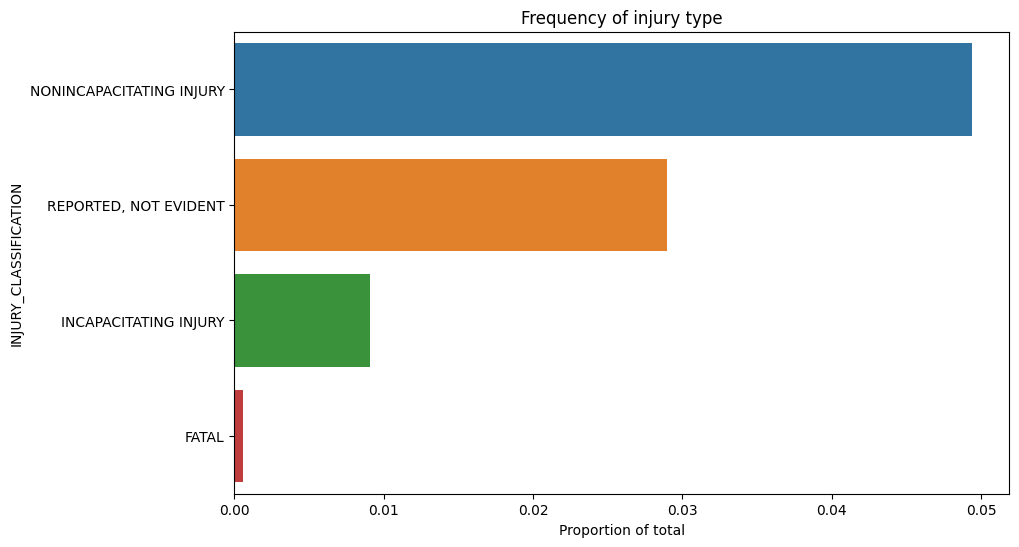

In [31]:
# Distribution of our target classes
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=people_df.INJURY_CLASSIFICATION.value_counts(normalize=True).drop('NO INDICATION OF INJURY').index, 
            x=people_df.INJURY_CLASSIFICATION.value_counts(normalize=True).drop('NO INDICATION OF INJURY'),
           orient='h', ax=ax)
plt.title('Frequency of injury type')
plt.xlabel('Proportion of total');

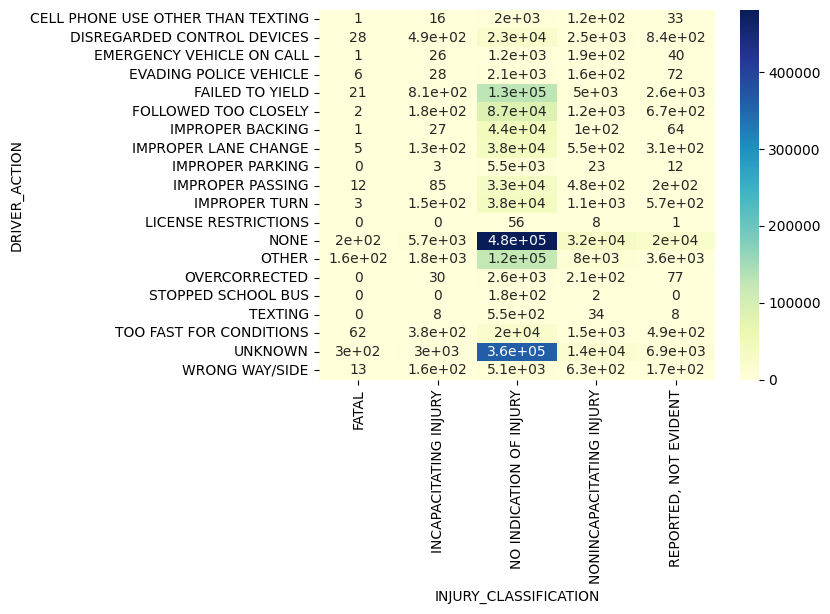

In [32]:
sns.heatmap(pd.crosstab(people_.DRIVER_ACTION, people_.INJURY_CLASSIFICATION),
            annot=True, cmap="YlGnBu");

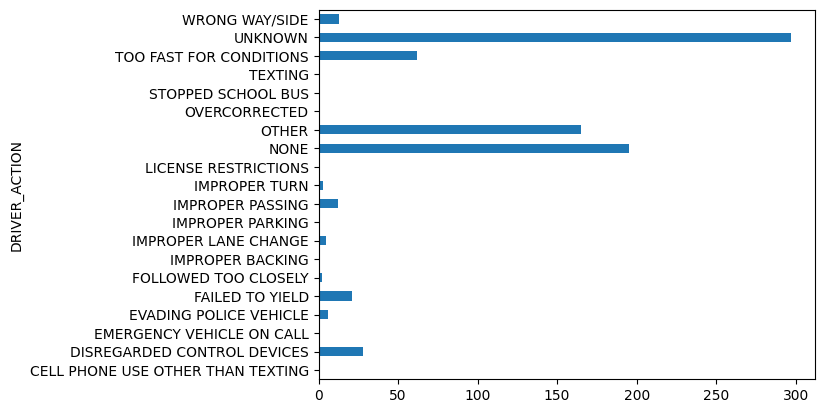

In [33]:
# Driver action with fatalities
pd.crosstab(people_.DRIVER_ACTION, people_.INJURY_CLASSIFICATION)['FATAL'].plot.barh();

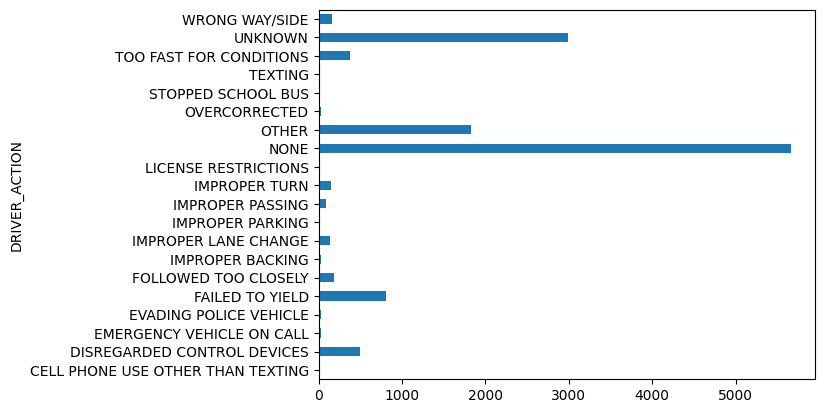

In [34]:
# Driver action with inapacitating injuries
pd.crosstab(people_.DRIVER_ACTION, people_.INJURY_CLASSIFICATION)['INCAPACITATING INJURY'].plot.barh();

In [35]:
# Distribution of breathalyzer tests
people_.BAC_RESULT.value_counts()

BAC_RESULT
TEST NOT OFFERED                   1491543
TEST REFUSED                         15649
TEST PERFORMED, RESULTS UNKNOWN       3617
TEST TAKEN                            2672
Name: count, dtype: int64

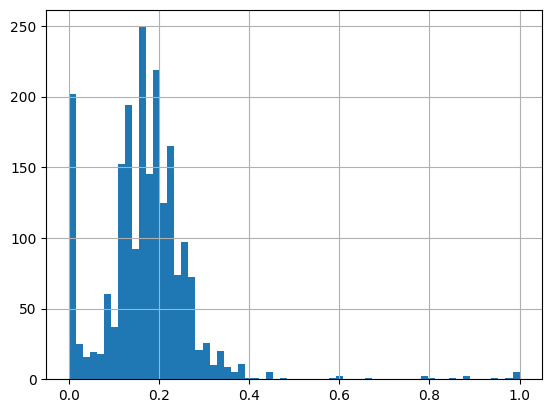

In [36]:
people_df['BAC_RESULT VALUE'].hist(bins='auto');

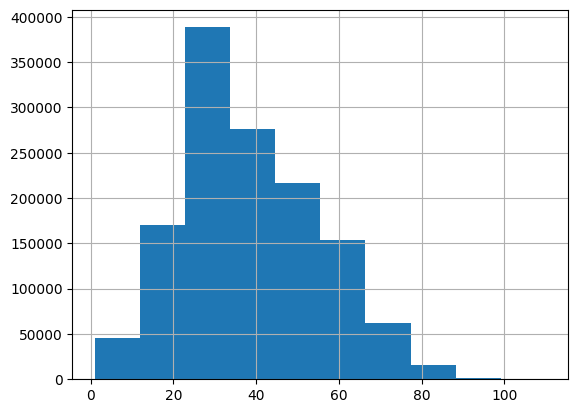

In [37]:
people_df[people_df['AGE'] > 0]['AGE'].hist();

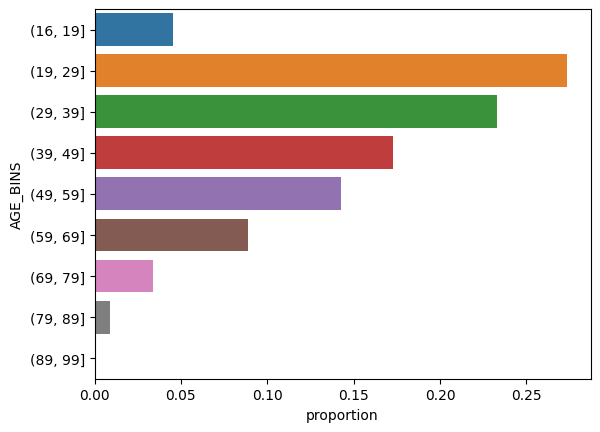

In [38]:
people_df['AGE_BINS'] = pd.cut(x=people_df['AGE'], bins=[16, 19, 29, 39, 49, 59, 69, 79, 89, 99])

sns.barplot(y=people_df.AGE_BINS.value_counts(normalize=True).index, x=people_df.AGE_BINS.value_counts(normalize=True),
           orient='h');

How does Age relate to injury?

In [39]:
pd.crosstab(people_df.AGE_BINS, people_df.INJURY_CLASSIFICATION)

INJURY_CLASSIFICATION,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
AGE_BINS,,,,,
"(16, 19]",39,809,48879,4837,2444
"(19, 29]",214,4100,303095,23928,13067
"(29, 39]",187,3235,261154,17919,10609
"(39, 49]",122,2196,196103,11784,7496
"(49, 59]",111,2088,160445,10123,6630
"(59, 69]",88,1469,99850,6769,4017
"(69, 79]",50,645,38010,2557,1423
"(79, 89]",27,223,10094,811,397
"(89, 99]",3,20,1119,99,37


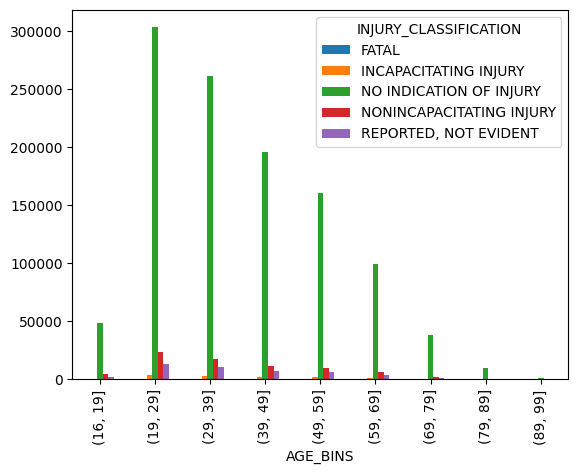

In [40]:
pd.crosstab(people_df.AGE_BINS, people_df.INJURY_CLASSIFICATION).plot.bar();

It appears as though people in their 20s are getting into a lot of wrecks, with all manner of outcomes, with the rate slowing with age. However, we can't conclude from this dataset alone that younger people are more likely to get into crashes. We would need to compare to general driver demographic data to see if this is proportional or not and calculate accident rates.

Our initial models predict that sex is a strong predictor for higher levels of injury/fatalities:

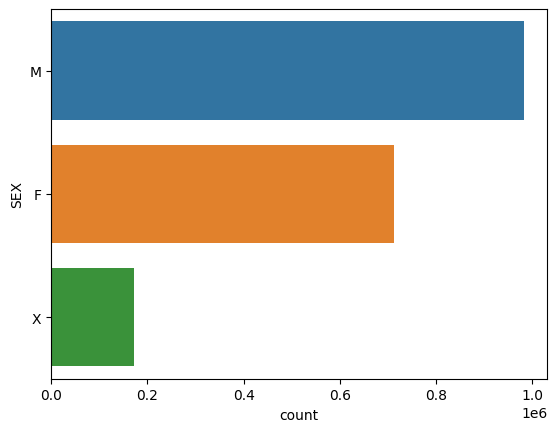

In [41]:
sns.barplot(y=people_df.SEX.value_counts().index, x=people_df.SEX.value_counts(),
           orient='h');

In [42]:
pd.crosstab(people_df.SEX, people_df.INJURY_CLASSIFICATION)

INJURY_CLASSIFICATION,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
SEX,,,,,
F,269,7256,633149,44290,28529
M,751,9649,898498,47942,25400
X,14,103,171978,318,203
